# Machine Learning Foundation
## Autoencoders

### MNIST Data
We'll be working with the famous MNIST dataset, which contains 70,000 handwritten black-and-white images, which are traditionally split into 60k traning images and 10k validation images.

In [1]:
from keras.datasets import mnist
import numpy as np
np.set_printoptions(precision=2)

import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test)=mnist.load_data();

import warnings
warnings.filterwarnings('ignore')

#### Preprocess MNIST

In [2]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [3]:
## flatten the data
x_train.shape

(60000, 28, 28)

In [4]:
x_train_flat=x_train.reshape(len(x_train),-1)
x_test_flat=x_test.reshape(len(x_test),-1)
print(x_train_flat.shape)
print(x_test_flat.shape)

(60000, 784)
(10000, 784)


In [5]:
## Scale the data

from sklearn.preprocessing import MinMaxScaler
ss=MinMaxScaler()
x_train_flat_ss=ss.fit_transform(x_train_flat)
#x_test_flat_ss=ss.transform(x_test_flat)

In [6]:
from sklearn.decomposition import PCA

def mnist_pca(x_data, n_components):
    pca=PCA(n_components=n_components)
    
    fit_pca=pca.fit(x_train_flat_ss)
    
    print("Variance explained with {} components".format(n_components),
         round(sum(fit_pca.explained_variance_ratio_),2))
    
    return fit_pca, fit_pca.transform(x_data)

In [7]:
pca_full, mnist_data_full=mnist_pca(x_train_flat_ss, 784)

Variance explained with 784 components 1.0


In [8]:
len(np.cumsum(pca_full.explained_variance_ratio_))

784

Text(0, 0.5, 'Proportion of variance explained')

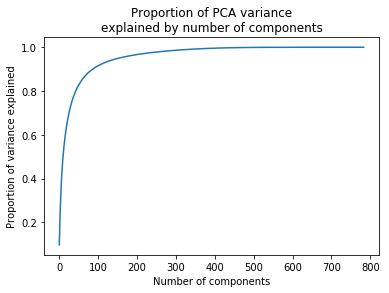

In [9]:
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.title("Proportion of PCA variance\nexplained by number of components")
plt.xlabel("Number of components")
plt.ylabel("Proportion of variance explained")

We need about 250 components to explained 90% of the variance in the data. For visualization purposes, let's extract just two components and plot them:

In [10]:
pca_2, mnist_data_2=mnist_pca(x_train_flat_ss, 2)

Variance explained with 2 components 0.17


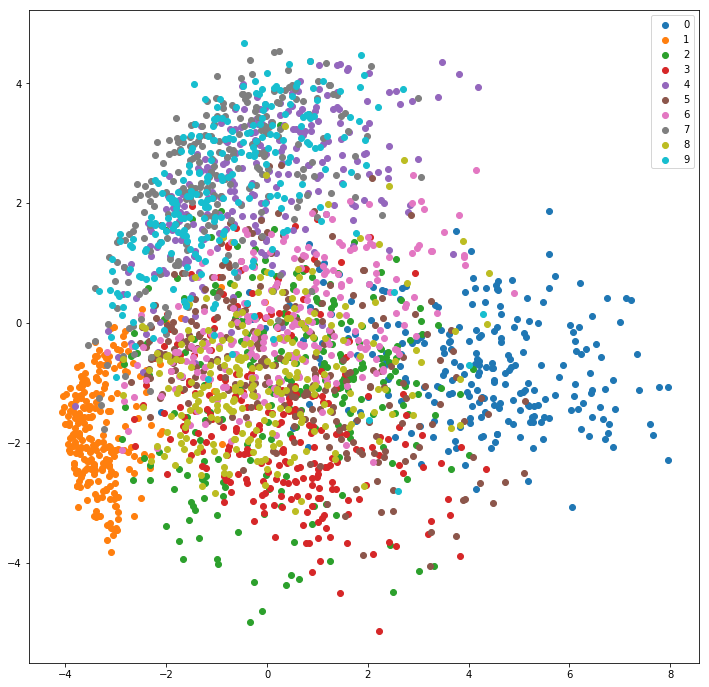

In [11]:
num_images_per_class=250

fig=plt.figure(figsize=(12,12))
for number in list(range(10)):
    mask=y_train==number
    
    ## use the first 250 true index
    mask=np.where(mask)[0][:num_images_per_class]
    
    x_data=mnist_data_2[mask, 0]
    y_data=mnist_data_2[mask, 1]
    
    plt.scatter(x_data, y_data, label=number, alpha=1)
    
plt.legend()   

We can already see that the latent features PCA is learning somewhat disentangle the features here, and a neural network could certainly help with this.

#### Scoring PCA
what we really care about is: how good is PCA at creating a low dimensional representation of the MNIST data?
As with all models, we should test performance on a different dataset than we trained on:

In [12]:
pca_64, mnist_data_64=mnist_pca(x_train_flat_ss, 64)

Variance explained with 64 components 0.86


In [13]:
x_test_flat_ss=ss.fit_transform(x_test_flat)

In [14]:
x_test_flat_64=pca_64.transform(x_test_flat_ss)
x_test_reconstructed_64=pca_64.inverse_transform(x_test_flat_64)

In [15]:
x_test_reconstructed_64.shape

(10000, 784)

In [16]:
true = x_test_flat_ss
reconstructed = x_test_reconstructed_64

In [17]:
def mse_reconstruction(true, reconstructed):
    return np.sum(np.power(true - reconstructed, 2) / true.shape[1])

In [18]:
mse_reconstruction(true, reconstructed)

90.58181

### Simple AE
Now let's build an autoencoder! Fundamentally, an autoencoder is an neural network where the input is the same as the output.

In [19]:
from keras.layers import Input, Dense
from keras.models import Model

In practice, when implementign autoencoders using Keras, we define three models:
* The "full autoencoder", here full_model, will take inputs and try to reconstruct thme
* The "encoder", here encoder_model, will take inputs and try to construct them
* The "decoder", here decoder_model, will take the latent space and try to reconstruct it

In [20]:
ENCODING_DIM=64

# Encoder model
inputs=Input(shape=(784,))
encoded=Dense(ENCODING_DIM, activation="sigmoid")(inputs)
encoder_model=Model(inputs, encoded, name='encoder')

# Decoder model
encoded_inputs=Input(shape=(ENCODING_DIM,), name='encoding')
reconstruction=Dense(784, activation="sigmoid")(encoded_inputs)
decoder_model=Model(encoded_inputs, reconstruction, name='decoder')

# Defining the full model as the combination of the two
outputs=decoder_model(encoder_model(inputs))
full_model=Model(inputs, outputs, name='full_ae')

In [21]:
full_model=Model(inputs=inputs,
                outputs=outputs)

full_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [22]:
history=full_model.fit(x_train_flat, x_train_flat, shuffle=True, epochs=1, batch_size=32)

1875/1875 [==============================] - 2s 1ms/step - loss: 0.2059 - accuracy: 0.0132


Feel free to do `.summary` and `visual` on this trained model now.
Recall that with Keras, training the model with layers 1-5 trains the smaller model simultaneously, as long as they are built off of the same underlying objects!

In [23]:
encoded_images = encoder_model.predict(x_test_flat)
encoded_images.shape

(10000, 64)

So, the "encoder model" has already been trained! For example, the encoding for the first image in the test dataset is:

In [24]:
encoded_images[0]

array([1.00e+00, 1.00e+00, 9.96e-01, 4.85e-05, 9.70e-01, 3.37e-02,
       2.11e-01, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 9.99e-01,
       3.53e-03, 9.71e-01, 2.01e-01, 1.00e+00, 9.97e-01, 1.00e+00,
       1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 9.98e-01, 9.87e-01,
       1.00e+00, 7.08e-01, 4.48e-01, 2.93e-01, 9.78e-04, 1.00e+00,
       1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 9.98e-01, 9.40e-01,
       1.00e+00, 9.19e-01, 3.42e-02, 1.00e+00, 1.00e+00, 2.54e-01,
       1.00e+00, 6.57e-01, 3.63e-03, 1.00e+00, 2.06e-04, 9.97e-01,
       1.17e-01, 1.00e+00, 3.35e-03, 1.00e+00, 1.00e+00, 7.64e-01,
       9.81e-01, 1.00e+00, 1.00e+00, 1.00e+00, 8.57e-04, 1.00e+00,
       4.80e-01, 8.45e-02, 1.00e+00, 7.46e-01], dtype=float32)

#### Exercise 1
Using decoder to generate the reconstructed images  
Compute the pixel-wise distance between the reconstructed images and the original images

In [25]:
decoded_images=full_model.predict(x_test_flat)
decoded_images.shape

(10000, 784)

In [26]:
true = x_test_flat
reconstructed = decoded_images

mse_reconstruction(true, reconstructed)

318.44003

#### Exercise 2
One of the reasons this model does worse thatn PCA is that it isn't a "Deep Learning" model

In [27]:
ENCODING_DIM=64
HIDDEN_DIM=256

# Encoder model
inputs=Input(shape=(784,))
encoded=Dense(ENCODING_DIM, activation="sigmoid")(inputs)
encoder_hidden = Dense(HIDDEN_DIM, activation="sigmoid")(encoded)
encoder_model=Model(inputs, encoded, name='encoder')

# Decoder model
encoded_inputs=Input(shape=(ENCODING_DIM,), name='encoding')
decoder_hidden = Dense(HIDDEN_DIM, activation="relu")(encoded_inputs)
reconstruction=Dense(784, activation="sigmoid")(encoded_inputs)
decoder_model=Model(encoded_inputs, reconstruction, name='decoder')

# Defining the full model as the combination of the two
outputs=decoder_model(encoder_model(inputs))
full_model=Model(inputs, outputs, name='full_ae')

In [28]:
full_model = Model(inputs=inputs, 
                   outputs=outputs)

full_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

In [29]:
history = full_model.fit(x_train_flat, x_train_flat, shuffle=True, epochs=2, batch_size=32)

Epoch 1/2
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2100 - accuracy: 0.0123
Epoch 2/2
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1527 - accuracy: 0.0099


In [30]:
# Generate reconstructed images
decoded_images = full_model.predict(x_test_flat)
mse_reconstruction(decoded_images, x_test_flat)
### END SOLUTION

247.6123

#### You've probably noticed that we've only been training our model for one epoch. Let's test to see how our model's reconstruction loss decreases as we train it more

In [31]:
def train_ae_epochs(num_epochs=1):
### BEGIN SOLUTION
    ENCODING_DIM = 64
    HIDDEN_DIM = 256

    # Encoder model
    inputs = Input(shape=(784,)) 
    encoded = Dense(ENCODING_DIM, activation="relu")(inputs)
    encoder_hidden = Dense(HIDDEN_DIM, activation="sigmoid")(encoded)
    encoder_model = Model(inputs, encoded, name='encoder')

    # Decoder model
    encoded_inputs = Input(shape=(ENCODING_DIM,), name='encoding')
    decoder_hidden = Dense(HIDDEN_DIM, activation="relu")(encoded_inputs)
    reconstruction = Dense(784, activation="sigmoid")(decoder_hidden)
    decoder_model = Model(encoded_inputs, reconstruction, name='decoder')

    # Defining the full model as the combination of the two
    outputs = decoder_model(encoder_model(inputs))
    full_model = Model(inputs, outputs, name='full_ae')
    
    full_model = Model(inputs=inputs, 
                       outputs=outputs)

    full_model.compile(optimizer='rmsprop',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
    mse_res = []
    for i in range(num_epochs):
        history = full_model.fit(x_train_flat, x_train_flat, shuffle=True, epochs=1, batch_size=32)
    
        decoded_images = full_model.predict(x_test_flat)
        reconstruction_loss = mse_reconstruction(decoded_images, x_test_flat)
        mse_res.append(reconstruction_loss)
        print("Reconstruction loss after epoch {0} is {1}"
              .format(i+1, reconstruction_loss))
### END SOLUTION       
    return mse_res

In [32]:
train_ae_epochs(5)

1875/1875 [==============================] - 4s 2ms/step - loss: 0.1191 - accuracy: 0.0119
Reconstruction loss after epoch 1 is 92.51827239990234
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0873 - accuracy: 0.0128
Reconstruction loss after epoch 2 is 83.27131652832031
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0819 - accuracy: 0.0132
Reconstruction loss after epoch 3 is 54.964508056640625
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0793 - accuracy: 0.0137
Reconstruction loss after epoch 4 is 53.63439178466797
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0778 - accuracy: 0.0138
Reconstruction loss after epoch 5 is 49.82315444946289


[92.51827, 83.27132, 54.964508, 53.63439, 49.823154]

### Variational autoencoder

At a high level, the actual steps of a VAE are:

1. The first neural network, the "encoder", predicts two vectors for each image, which will then be interpreted as means and standard deviations and transformed into a normal distribution.
3. The second neural network, the "decoder", takes the results of this operation and tries to reconstruct the original image.
4. The entire system is trained with backpropagation. At each iteration, _two_ losses are computed:
    * One loss simply penalizes the system for producing images that don't match the original images.
    * The other loss penalizes the encoder model for not correctly producing statistics from the image that match a standard normal distribution. 
   
The details are contained in the presentation. 

In [33]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf

The function below involves transforming the VAE encoder outputs into a normally distributed output. 

Recall that the VAE encoder generates vectors representing $\mu$ and $log(\sigma)$. These are then transformed into the generator input via 

$$ G_{in} = \mu + \sigma * \epsilon $$

where $ \epsilon $ ~ $ N(0, 1) $.

In [34]:
def sampling(args):
    """
    Tansforms parameters defining the latent space into normal distribution
    """
    
    # Need to unpack arguments like this because of the way the Keras "Lambda" function works
    mu, log_sigma=args
    # by default, random_normal has mean=0, std=1.0
    epsilon=K.random_normal(shape=tf.shape(mu))
    sigma=K.exp(log_sigma)
    return mu+K.exp(0.5*sigma)*epsilon

In [36]:
hidden_dim = 256
batch_size = 128
latent_dim = 2 
# this is the dimension of each of the vectors representing the two parameters
# that will get transformed into a normal distribution
epochs = 1

# VAE model=encoder + decoder
# build encoder model
inputs=Input(shape=(784,), name='encoder_input')
x=Dense(hidden_dim, activation='relu')(inputs)

z_mean=Dense(latent_dim, name='z_mean')(x)
z_log_var=Dense(latent_dim, name='z_log_var')(x)

z=Lambda(sampling, name='z')([z_mean, z_log_var])
# z is now one n dimensional vector representation the inputs
encoder_model=Model(inputs, [z_mean, z_log_var, z], name='encoder')

In [37]:
# build decoder model
latent_inputs=Input(shape=(latent_dim,),)
x=Dense(hidden_dim, activation='relu')(latent_inputs)
outputs=Dense(784, activation='sigmoid')(x)
decoder_model=Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs=decoder_model(encoder_model(inputs)[2])
vae_model=Model(inputs, outputs, name='var_mlp')

#### Examine each layer

In [38]:
for i, layer in enumerate(vae_model.layers):
    print("Layer", i+1)
    print("Name", layer.name)
    print("Input shape", layer.input_shape)
    print("Output shape", layer.output_shape)
    if not layer.weights:
        print("No weights for this layer")
    for i, weight in enumerate(layer.weights):
        print("Weights", i+1)
        print("Name", weight.name)
        print("Weights shape:", weight.shape.as_list())

Layer 1
Name encoder_input
Input shape [(None, 784)]
Output shape [(None, 784)]
No weights for this layer
Layer 2
Name encoder
Input shape (None, 784)
Output shape [(None, 2), (None, 2), (None, 2)]
Weights 1
Name dense_11/kernel:0
Weights shape: [784, 256]
Weights 2
Name dense_11/bias:0
Weights shape: [256]
Weights 3
Name z_mean/kernel:0
Weights shape: [256, 2]
Weights 4
Name z_mean/bias:0
Weights shape: [2]
Weights 5
Name z_log_var/kernel:0
Weights shape: [256, 2]
Weights 6
Name z_log_var/bias:0
Weights shape: [2]
Layer 3
Name decoder
Input shape (None, 2)
Output shape (None, 784)
Weights 1
Name dense_12/kernel:0
Weights shape: [2, 256]
Weights 2
Name dense_12/bias:0
Weights shape: [256]
Weights 3
Name dense_13/kernel:0
Weights shape: [256, 784]
Weights 4
Name dense_13/bias:0
Weights shape: [784]


#### Exercise 4
Compute the loss for variational autoencoders. It should have two components:  
* 1. the reconstruction loss. Use the binary_crossentroy Keras function to compute the loss
* 2. The KL loss. Use the formula above, and the z_mean and z_log_var functions to fill in the missing piece

In [47]:
z_mean

<tf.Tensor 'z_mean/BiasAdd_1:0' shape=(None, 2) dtype=float32>

In [52]:
reconstruction_loss=binary_crossentropy(inputs, outputs)
reconstruction_loss *=784

In [53]:
kl_loss=0.5*(K.exp(z_log_var)-(1+z_log_var)+K.square(z_mean))
kl_loss=K.sum(kl_loss, axis=-1)
total_vae_loss=K.mean(reconstruction_loss+kl_loss)

In [54]:
kl_loss

<tf.Tensor 'Sum_2:0' shape=(None,) dtype=float32>

Compiling and fitting the model

In [55]:
vae_model.add_loss(total_vae_loss)

vae_model.compile(optimizer='rmsprop',
                  metrics=['accuracy'])
    
vae_model.summary()

TypeError: unhashable type: 'DictWrapper'

In [56]:
vae_model.fit(x_train_flat,
        epochs=epochs,
        batch_size=batch_size)

TypeError: 'NoneType' object is not callable

#### Exercise 5:

Compute the reconstruction error for the variational autoencoder. Is it higher or lower than for the autoencoder was after one epoch? Why do you think that is?

In [57]:
### BEGIN SOLUTION
# Generate reconstructed images
decoded_images = vae_model.predict(x_test_flat)
mse_reconstruction(decoded_images, x_test_flat)
### END SOLUTION

StagingError: in user code:

    C:\Users\Wang Xiaoyuan\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\Users\Wang Xiaoyuan\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Wang Xiaoyuan\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Wang Xiaoyuan\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Wang Xiaoyuan\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Wang Xiaoyuan\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    C:\Users\Wang Xiaoyuan\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    C:\Users\Wang Xiaoyuan\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\Wang Xiaoyuan\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\functional.py:386 call
        inputs, training=training, mask=mask)
    C:\Users\Wang Xiaoyuan\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\functional.py:507 _run_internal_graph
        args, kwargs = node.map_arguments(tensor_dict)
    C:\Users\Wang Xiaoyuan\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\node.py:152 map_arguments
        return (tensor_dict[kt_id].pop(),), {}

    IndexError: pop from empty list
